In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class Mirror:
    def __init__(self, size, tilt_angle):
        self.size = size
        self.tilt_angle = tilt_angle * np.pi / 180
        self.middle_x = self.size / 2.0
        self.middle_y = 0.0

    # calculate rotated x coordinate
    def get_x(self, x):
        y = 0
        cos = np.cos(self.tilt_angle)
        sin = np.sin(self.tilt_angle)
        target_x = (x - self.middle_x) * cos - (y - self.middle_y) * sin + self.middle_x
        return target_x

    # calculate rotated y coordinate
    def get_y(self, x):
        y = 0
        cos = np.cos(self.tilt_angle)
        sin = np.sin(self.tilt_angle)
        target_y = (x - self.middle_x) * sin + (y - self.middle_y) * cos + self.middle_y
        return target_y

    # calculate the projection onto the line
    def k_parallel(self, k_vector):
        b = np.array([self.get_x(self.size) - self.get_x(0), self.get_y(self.size) - self.get_y(0)])
        b_norm = b / np.linalg.norm(b)
        result = np.dot(k_vector, b_norm) * b_norm
        return result

    # calculate the phase at a specific point on the mirror
    def phase_at(self, x, k_vector):
        r = np.array([self.get_x(x) - self.get_x(0), self.get_y(x) - self.get_y(0)])
        result = np.dot(self.k_parallel(k_vector), r)%(2*np.pi)
        return result

In [3]:
class Dmd:
    def __init__(self, tilt_angle, mirror_size, mirror_gap, nr_x) -> None:
        self.tilt_angle = tilt_angle * np.pi / 180
        self.mirror_size = mirror_size
        self.mirror_gap = mirror_gap
        self.nr_x = nr_x
        self.width = (mirror_size + mirror_gap) * nr_x - mirror_gap

    # check that values don't pass the boundaries
    def check_values(self, nr_x, s):
        if (s < 0) or (s > self.mirror_size): raise ValueError(f"Parameter s has to be inside [0, {self.mirror_size}], but value is {s}.")
        if (nr_x < 0) or (nr_x >= self.nr_x): raise ValueError(f"Parameter nr_x has to be inside [0, {self.nr_x}), but value is {nr_x}.")
    
    # calculate rotated x coordinate
    def get_x(self, nr_x, s):
        self.check_values(nr_x, s)
        cos = np.cos(self.tilt_angle)
        mirror_edge = (self.mirror_size + self.mirror_gap) * nr_x
        mirror_middle = self.mirror_size / 2.0
        x = mirror_edge + (s - mirror_middle) * cos + mirror_middle
        return x

    # calculate rotated y coordinate
    def get_y(self, nr_x, s):
        self.check_values(nr_x, s)
        sin = np.sin(self.tilt_angle)
        mirror_middle = self.mirror_size / 2.0
        y = (s - mirror_middle) * sin
        return y
    
    # get vector lying in the mirror plane
    def get_plane_vector(self, nr_x, s):
        x0 = self.get_x(nr_x, 0)
        y0 = self.get_y(nr_x, 0)
        x1 = self.get_x(nr_x, s)
        y1 = self.get_y(nr_x, s)
        return np.array([x1-x0, y1-y0])
    
    # get component of wave vector that is parallel to the mirror plane
    def get_parallel_wave_vector_component(self, nr_x, wave_vector):
        plane_vector = self.get_plane_vector(nr_x, self.mirror_size)
        plane_unit_vector = 1 / np.linalg.norm(plane_vector) * plane_vector
        parallel_wave_vector_component = (np.dot(wave_vector, plane_unit_vector) * plane_unit_vector)
        return parallel_wave_vector_component

    # get phase at specific point on mirror
    def get_phase_at(self, nr_x, s, wave_vector):
        parallel_wave_vector_component = self.get_parallel_wave_vector_component(nr_x, wave_vector)
        plane_vector = self.get_plane_vector(nr_x, s)
        phase = np.dot(parallel_wave_vector_component, plane_vector)
        return phase
    


In [4]:
class Simulation:
    def __init__(self, dmd:Dmd, in_beam, wavelength) -> None:
        self.dmd = dmd
        self.wave_vector = 2 * np.pi / wavelength * in_beam

    # calculate the field
    def calc_field_at(self, x, y):
        field = 0 + 0j
        # vector pointing to the field position
        r = np.array([x, y])
        
        # loop over all mirrors
        for i in range(self.dmd.nr_x):
            # loop over a mirror
            for s in range(self.dmd.mirror_size + 1):
                x0 = self.dmd.get_x(i, s)
                y0 = self.dmd.get_y(i, s)
                # vector pointing to huygen source
                m = np.array([x0, y0])
                #Punkte für die Aufgaben haben vector pointing from huygen source to field position
                r0 = r - m
                # adding complex field contribution to the field sum
                field += np.exp(1j * (np.dot(r0, self.dmd.get_plane_vector(i, s))))
        return field


# Dmd setup

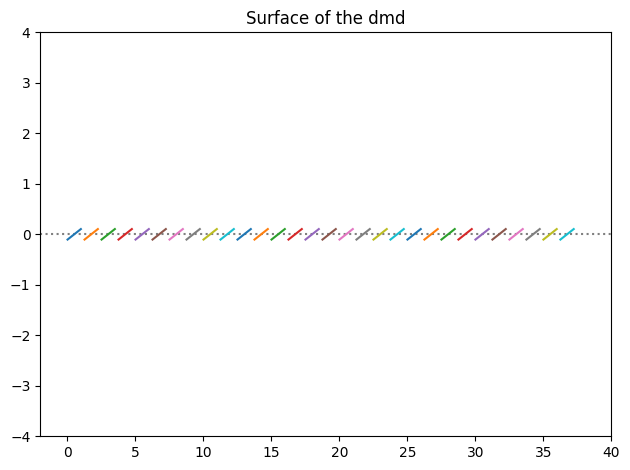

In [5]:
dmd = Dmd(12, 1, 0.25, 30)

s_values = np.linspace(0, dmd.mirror_size, 10)

for nr_x in range(dmd.nr_x):
    plt.plot([dmd.get_x(nr_x, s) for s in s_values], [dmd.get_y(nr_x, s) for s in s_values])

plt.title("Surface of the dmd")
plt.xlim(-2, 40)
plt.ylim(-4, 4)
plt.axhline(0, linestyle="dotted", zorder=-1, color="gray")
plt.tight_layout()
plt.show()

# Simulation setup

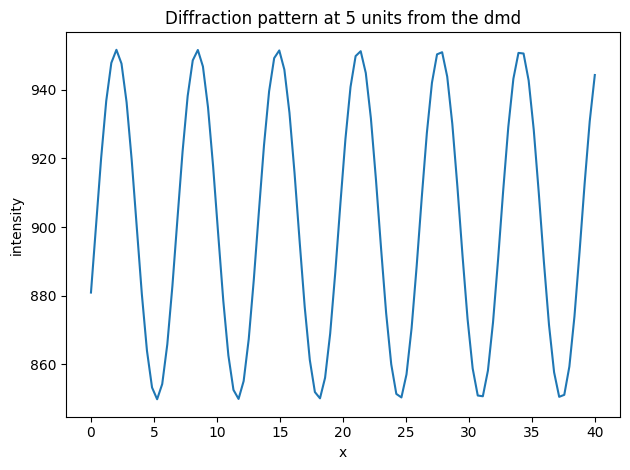

In [6]:
wavelength = 600e-9
phi = - 0 * np.pi / 180
in_beam = np.array([np.cos(phi), np.sin(phi)])
sim = Simulation(dmd, in_beam, wavelength)

plt.title(f"Diffraction pattern at {5} units from the dmd")
plt.plot(np.linspace(0, 40, 100), [np.linalg.norm(sim.calc_field_at(x, 5))**2 for x in np.linspace(0, 40, 100)])
plt.xlabel("x")
plt.ylabel("intensity")
plt.tight_layout()
plt.show()

# Only one mirror approach

In [7]:
mirror_size = 10
alpha = 12
mirror = Mirror(mirror_size, alpha)
wavelength = 1
phi = - 90 * np.pi / 180
k = 2 * np.pi / wavelength
k_vector = k * np.array([np.cos(phi), np.sin(phi)])

print(mirror.phase_at(1, k_vector))

s = np.linspace(0, mirror.size)

4.976837626242576


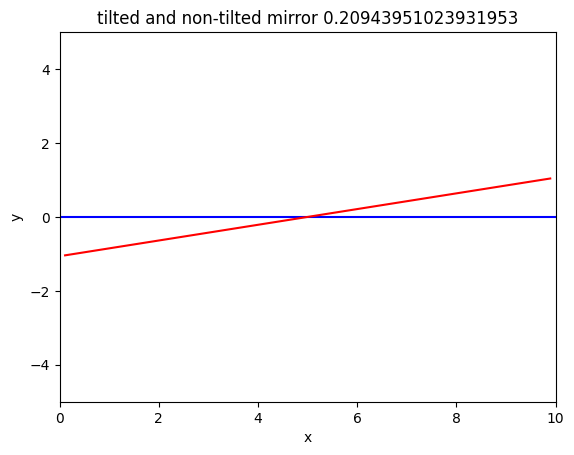

In [10]:
def visualize_mirror():
    # draw the non-tilted mirror
    plt.plot([x for x in s], [0 for x in s], color="blue")

    # draw the tilted mirror
    plt.plot([mirror.get_x(x) for x in s], [mirror.get_y(x) for x in s], color="red")

    # check if the vector is really parallel to the tilted mirror
    plt.scatter(mirror.k_parallel(k_vector)[0], mirror.k_parallel(k_vector)[1], color="green")
    plt.scatter(1.5*mirror.k_parallel(k_vector)[0], 1.5*mirror.k_parallel(k_vector)[1], color="green")
    plt.scatter(2*mirror.k_parallel(k_vector)[0], 2*mirror.k_parallel(k_vector)[1], color="green")

    plt.title(f"tilted and non-tilted mirror {mirror.tilt_angle}")
    plt.xlim(0, 10)
    plt.ylim(-5, 5)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()

visualize_mirror()

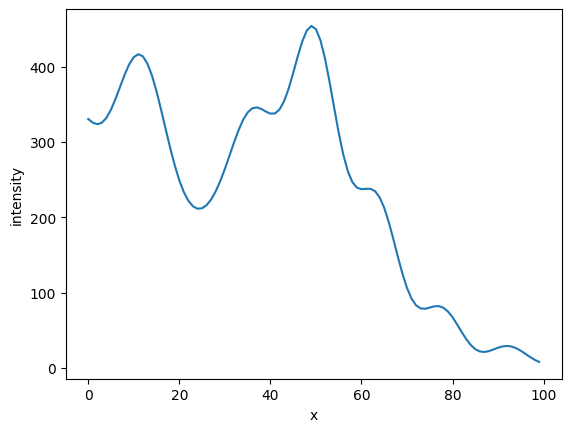

In [9]:
# define a complex field
field_length = 10
field_step = 0.1
field = np.zeros((int(field_length/field_step)), dtype=complex)
field_x = 0
field_y = 10

# loop over the field and calculate the contribution of all huygen sources
for i in range(len(field)):
    sum = 0 + 0j
    for x in s:
        # calculate vector between field point and huygen source
        r_0 = np.array([field_x - mirror.get_x(x), field_y - mirror.get_y(0)])

        # calculate new wavevector
        k_new = k*(r_0/np.linalg.norm(r_0))

        # calculate the phase of the huygen source
        phase = mirror.phase_at(mirror.get_x(x), k_vector)

        # sum up the contributions of all huygen sources to one field point
        sum += np.exp(1j*(np.dot(k_new, r_0) + phase))

    field_x += field_step

    # set the field at position i
    field[i] = sum

# print(field)


def visualize_field(field):
    plt.plot(range(len(field)), [np.linalg.norm(i)**2 for i in field])
    plt.xlabel("x")
    plt.ylabel("intensity")
    plt.show()

visualize_field(field)